# Term Project Machine Learning

### Import Libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

### Load Data

In [84]:
#load data
df = pd.read_csv('../data/spotify-2023.csv',encoding='latin-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


### Clean Data

In [85]:
df.dtypes

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

In [86]:
#Coverting streams and in_deezer_playlists into float
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')

#replace commas in in_shazam_charts so it's possible to convert it into int
df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=True).astype(float)

In [87]:
# missing values
missing_values = df.isnull().sum()
print(missing_values)

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  1
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists     79
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


In [88]:
# delete rows with missing values for 'key' and 'streams' to maintain the integrity and quality of dataset
# because we think these values are very important for the prediction
df = df.dropna(subset=['key'])
df = df.dropna(subset=['streams'])

In [89]:
missing_values = df.isnull().sum()
print(missing_values)

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists     75
in_deezer_charts         0
in_shazam_charts        41
bpm                      0
key                      0
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


In [90]:
df = df.fillna(-1)
missing_values = df.isnull().sum()
print(missing_values)

track_name              0
artist(s)_name          0
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [91]:
df['streams'] = df['streams'].astype('int64')
df['in_deezer_playlists'] = df['in_deezer_playlists'].astype('int64')
df['in_shazam_charts'] = df['in_shazam_charts'].astype('int64')

In [92]:
# Combine 'released_year', 'released_month', and 'released_day' into a single datetime column
df['release_date'] = pd.to_datetime(df['released_year'].astype(str) + '-' + 
                                      df['released_month'].astype(str) + '-' + 
                                      df['released_day'].astype(str), errors='coerce')

# Check the new 'release_date' column
print(df['release_date'].head())

0   2023-07-14
1   2023-03-23
2   2023-06-30
3   2019-08-23
4   2023-05-18
Name: release_date, dtype: datetime64[ns]


In [93]:
# One-Hot Encoding for 'mode', keep the original 'mode' column untouched
mode_encoded = pd.get_dummies(df['mode'], prefix='mode')

# concat one-hot encoded df to main df
df = pd.concat([df, mode_encoded], axis=1)

In [94]:
# new column for encoded 'key'
df['key_encoded'] = LabelEncoder().fit_transform(df['key'].astype(str))

# check encoded values
print(df[['mode', *mode_encoded.columns, 'key', 'key_encoded']].head(10))

    mode  mode_Major  mode_Minor key  key_encoded
0  Major        True       False   B            2
1  Major        True       False  C#            3
2  Major        True       False   F            7
3  Major        True       False   A            0
4  Minor       False        True   A            0
5  Major        True       False  C#            3
6  Minor       False        True   F            7
7  Major        True       False   F            7
8  Minor       False        True  C#            3
9  Minor       False        True   D            4


In [95]:
df['danceability_%'] = df['danceability_%'] / 100.0
df['valence_%'] = df['valence_%'] / 100.0
df['energy_%'] = df['energy_%'] / 100.0
df['acousticness_%'] = df['acousticness_%'] / 100.0
df['instrumentalness_%'] = df['instrumentalness_%'] / 100.0
df['liveness_%'] = df['liveness_%'] / 100.0
df['speechiness_%'] = df['speechiness_%'] / 100.0

In [96]:
df.dtypes

track_name                      object
artist(s)_name                  object
artist_count                     int64
released_year                    int64
released_month                   int64
released_day                     int64
in_spotify_playlists             int64
in_spotify_charts                int64
streams                          int64
in_apple_playlists               int64
in_apple_charts                  int64
in_deezer_playlists              int64
in_deezer_charts                 int64
in_shazam_charts                 int64
bpm                              int64
key                             object
mode                            object
danceability_%                 float64
valence_%                      float64
energy_%                       float64
acousticness_%                 float64
instrumentalness_%             float64
liveness_%                     float64
speechiness_%                  float64
release_date            datetime64[ns]
mode_Major               

In [97]:
df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,release_date,key_encoded
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,8.570000e+02,857.000000,857.000000,857.000000,...,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857,857.000000
mean,1.551925,2018.297550,6.031505,13.739790,5204.997666,11.959160,5.133554e+08,67.383897,51.044341,96.751459,...,122.842474,0.672730,0.512194,0.643396,0.266441,0.016114,0.181750,0.103967,2018-10-01 15:14:04.340723200,5.158693
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,-1.000000,...,65.000000,0.230000,0.040000,0.140000,0.000000,0.000000,0.030000,0.020000,1930-01-01 00:00:00,0.000000
25%,1.000000,2020.000000,3.000000,5.000000,859.000000,0.000000,1.391938e+08,13.000000,7.000000,8.000000,...,100.000000,0.570000,0.320000,0.530000,0.050000,0.000000,0.100000,0.040000,2020-06-28 00:00:00,3.000000
50%,1.000000,2022.000000,5.000000,13.000000,2226.000000,3.000000,2.849083e+08,34.000000,38.000000,30.000000,...,121.000000,0.700000,0.510000,0.660000,0.170000,0.000000,0.120000,0.060000,2022-04-08 00:00:00,5.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,6.740727e+08,85.000000,85.000000,99.000000,...,142.000000,0.780000,0.700000,0.760000,0.420000,0.000000,0.240000,0.120000,2022-11-04 00:00:00,8.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,965.000000,...,206.000000,0.960000,0.970000,0.970000,0.970000,0.910000,0.970000,0.640000,2023-07-14 00:00:00,10.000000
std,0.864634,10.991135,3.567138,9.287652,7944.032885,19.194211,5.714855e+08,86.562405,50.407409,169.396393,...,28.196567,0.146532,0.235946,0.160563,0.256881,0.085707,0.135695,0.100909,NaN,3.227441


In [98]:
df.head(10)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,release_date,mode_Major,mode_Minor,key_encoded
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,0.89,0.83,0.31,0.00,0.08,0.04,2023-07-14,True,False,2
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,0.61,0.74,0.07,0.00,0.10,0.04,2023-03-23,True,False,3
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,0.32,0.53,0.17,0.00,0.31,0.06,2023-06-30,True,False,7
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,0.58,0.72,0.11,0.00,0.11,0.15,2019-08-23,True,False,0
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,0.23,0.80,0.14,0.63,0.11,0.06,2023-05-18,False,True,0
5,Sprinter,"Dave, Central Cee",2,2023,6,1,2186,91,183706234,67,...,0.66,0.58,0.19,0.00,0.08,0.24,2023-06-01,True,False,3
6,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2,2023,3,16,3090,50,725980112,34,...,0.83,0.76,0.48,0.00,0.08,0.03,2023-03-16,False,True,7
7,Columbia,Quevedo,1,2023,7,7,714,43,58149378,25,...,0.26,0.71,0.37,0.00,0.11,0.04,2023-07-07,True,False,7
8,fukumean,Gunna,1,2023,5,15,1096,83,95217315,60,...,0.22,0.62,0.12,0.00,0.28,0.09,2023-05-15,False,True,3
9,La Bebe - Remix,"Peso Pluma, Yng Lvcas",2,2023,3,17,2953,44,553634067,49,...,0.56,0.48,0.21,0.00,0.08,0.33,2023-03-17,False,True,4


### Histogram

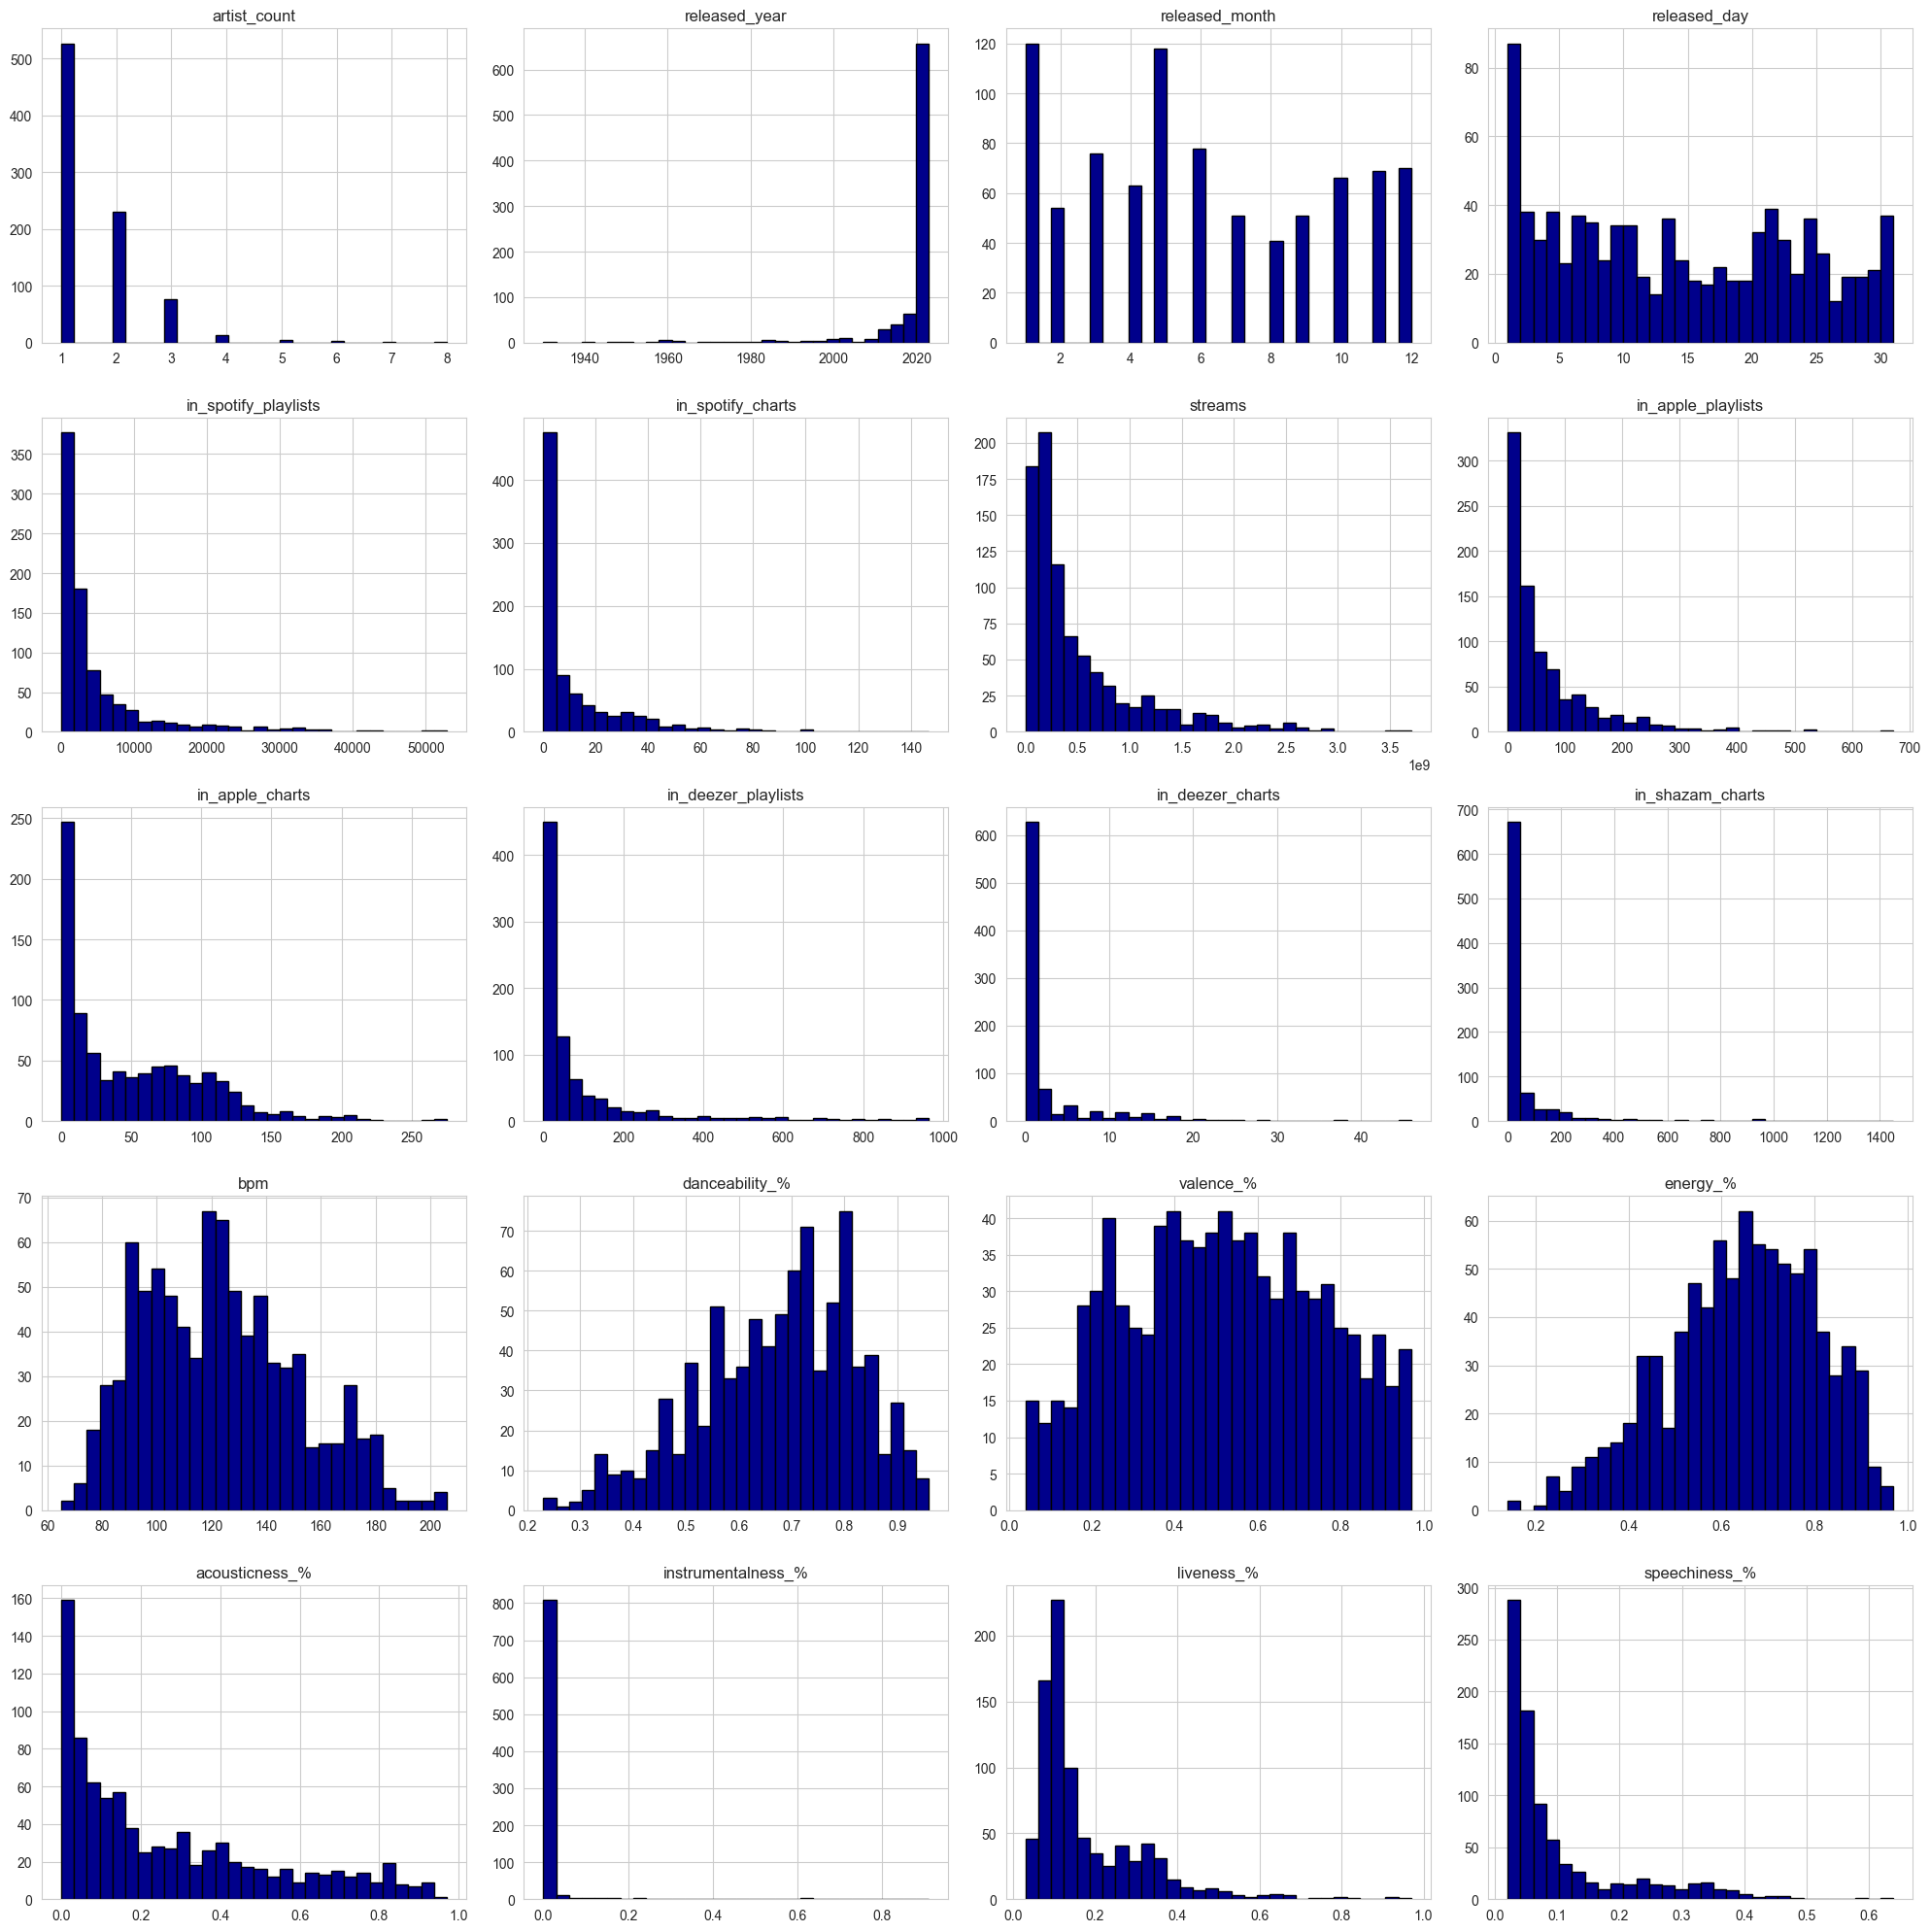

In [99]:
sns.set_style("whitegrid")

# Plotting histograms for numerical columns
df.select_dtypes(include=['float64', 'int64']).hist(bins=30, figsize=(20,20), color='darkblue', edgecolor='black')
plt.tight_layout()  
plt.show()

### Correlation Matrix

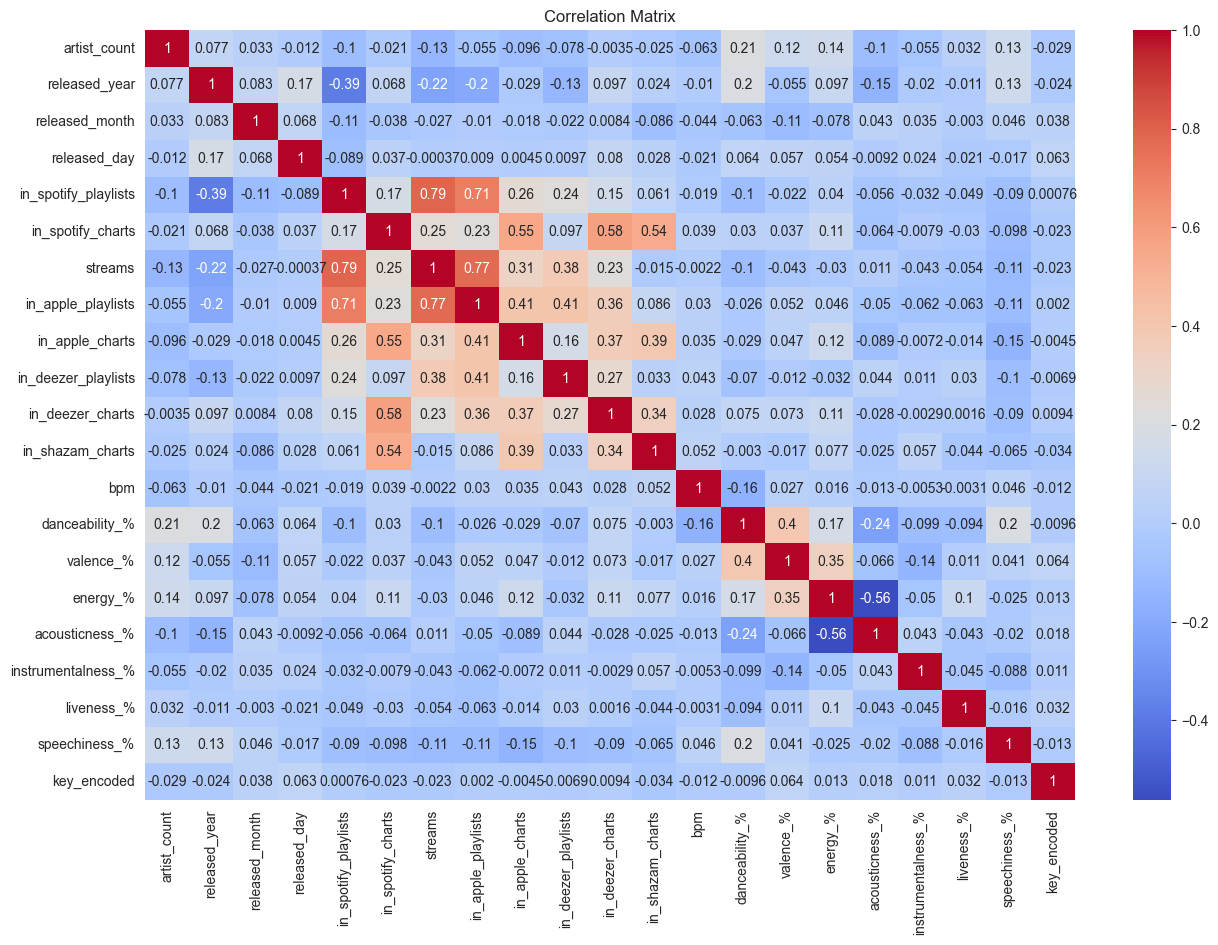

In [100]:
# Select all numerical columns
numeric_data = df.select_dtypes(include=[np.number])

# correlation matrix
correlation_matrix = numeric_data.corr()

# Visualize with heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Streaming Prediction(Random Forest)

#### Default Hyperparameters

In [101]:
columns_to_use = [
    'artist_count', 'released_year', 'released_month', 'released_day',
    'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 
    'in_deezer_playlists', 'in_deezer_charts', 'bpm', 'danceability_%', 
    'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 
    'liveness_%', 'speechiness_%', 'key_encoded'
]

# Split the data into train-validation-test sets
X = df[columns_to_use]
y = df['streams']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [102]:
# Random Forest Regressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

# Predict with validation set
y_val_pred = rf_reg.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 6.708522897953063e+16
Mean Absolute Error (MAE): 165068652.99604648
R^2 Score: 0.7480262160373459


In [103]:
# Predict with test set
y_test_pred = rf_reg.predict(X_test)

# Evaluate the model (test set)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"R^2 Score: {r2_test}")

Test Set Evaluation:
Mean Squared Error (MSE): 8.154733177370349e+16
Mean Absolute Error (MAE): 157749396.82
R^2 Score: 0.8350598409040159


In [104]:
# Retrive feature importance from the random forest model
feature_importances = rf_reg.feature_importances_
features_df = pd.DataFrame({
    'Feature': columns_to_use,
    'Importance': feature_importances
})

print("Feature Importances:")
print(features_df.sort_values(by='Importance', ascending=False))

Feature Importances:
                 Feature  Importance
4   in_spotify_playlists    0.758510
1          released_year    0.063316
6     in_apple_playlists    0.044669
5      in_spotify_charts    0.020120
8    in_deezer_playlists    0.014207
11        danceability_%    0.013024
13              energy_%    0.011066
10                   bpm    0.010216
14        acousticness_%    0.009628
16            liveness_%    0.009376
7        in_apple_charts    0.008982
2         released_month    0.007924
12             valence_%    0.007506
3           released_day    0.006944
18           key_encoded    0.004822
9       in_deezer_charts    0.003713
17         speechiness_%    0.003543
0           artist_count    0.001243
15    instrumentalness_%    0.001191


#### Best Hyperparameters(via GridSearch)

In [105]:
# Define ranges of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestRegressor with GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Predict using the best model
y_val_pred = grid_search.best_estimator_.predict(X_val)

# Evaluate the model's performance
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\Mia-adm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
268 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Mia-adm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Mia-adm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Mia-adm\AppData\Local\Programs\Python\Python312\Lib\site-packages\skle

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error (MSE): 6.8295850881581224e+16
Mean Absolute Error (MAE): 169392668.7270337
R^2 Score: 0.7434790901461781


In [106]:
# Predict with test set
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance on test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"R^2 Score: {r2_test}")

Test Set Evaluation:
Mean Squared Error (MSE): 7.518309109302654e+16
Mean Absolute Error (MAE): 166309452.73921522
R^2 Score: 0.8479323512310122


#### Feature Importance

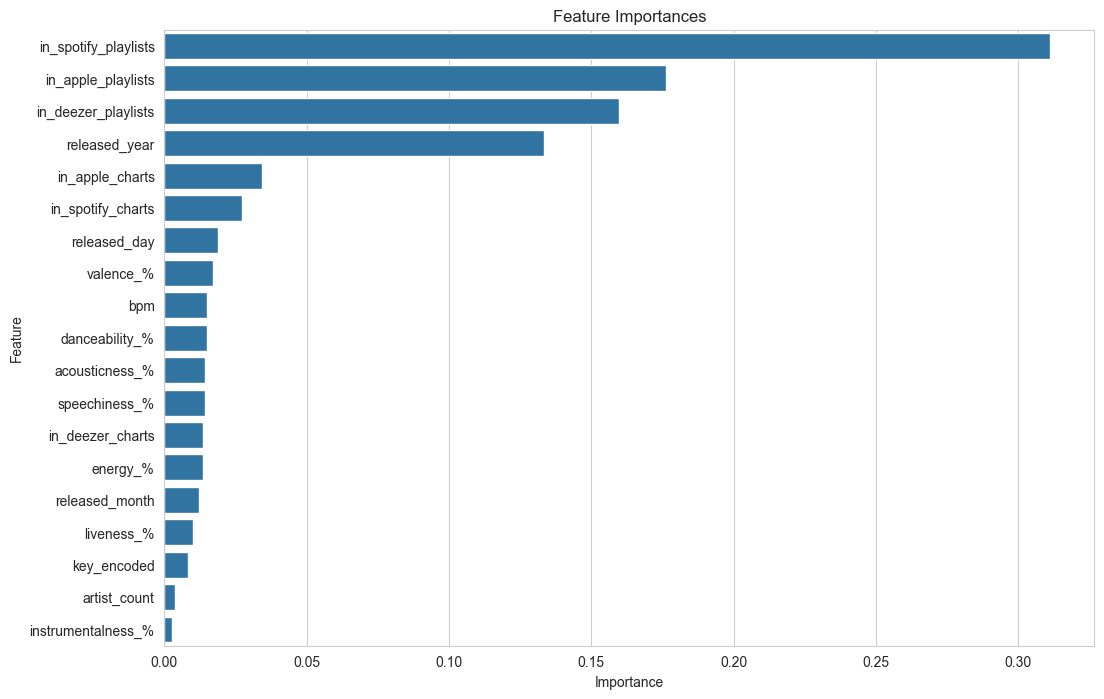

In [107]:
# Extract feature importances
importances = grid_search.best_estimator_.feature_importances_
features = columns_to_use

# New DataFrame for the importances
df_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_importances)
plt.title('Feature Importances')
plt.show()

### Actual vs. Predicted Streams

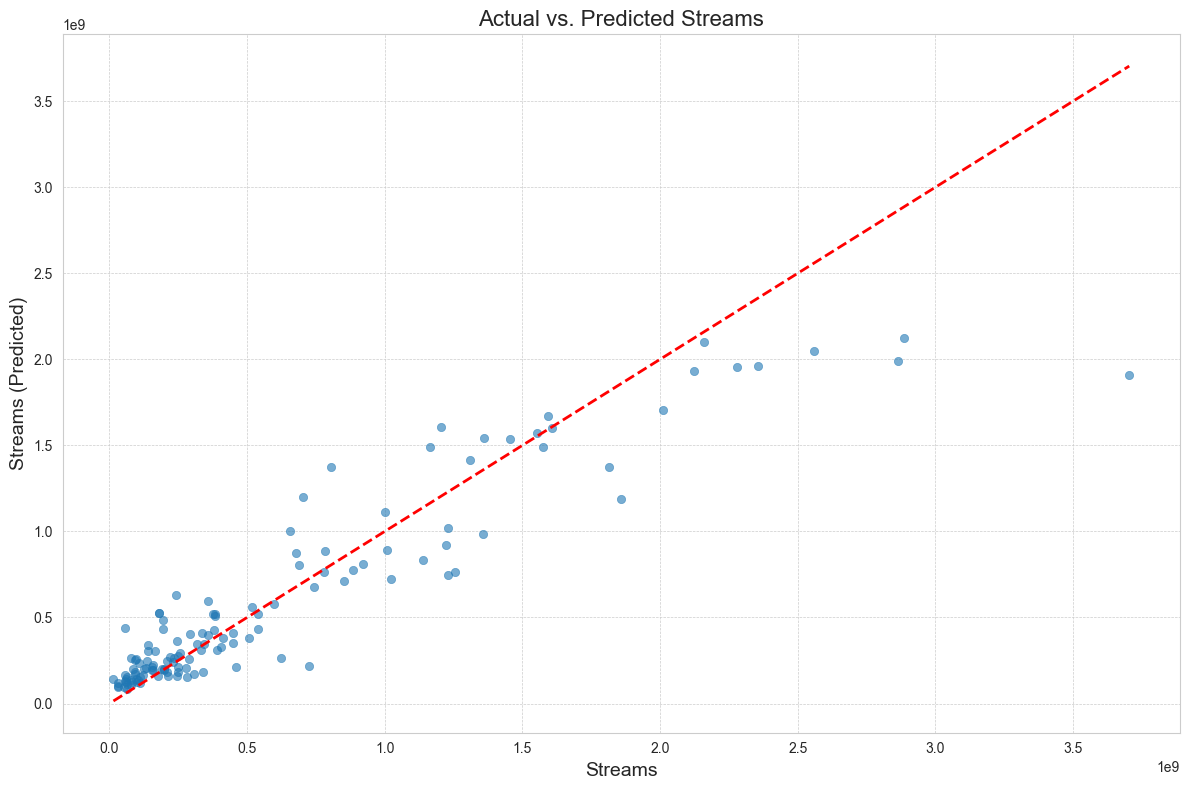

In [108]:
# Actual vs. Predicted Streams
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, edgecolor=None)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Streams', fontsize=14)
plt.ylabel('Streams (Predicted)', fontsize=14)
plt.title('Actual vs. Predicted Streams', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()